In [1]:
# !pip install pyyaml typeguard

# !pip install torch torchdiffeq

In [2]:
# !pip install numpy matplotlib scipy

In [3]:
%reset -f

In [4]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import matplotlib.pyplot as plt

In [5]:
torch.cuda.empty_cache()

In [6]:
# Step 1: Define the Neural ODE Model
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),   # Input dimension is 2, hidden layer size is 50
            nn.Tanh(),          # Activation function (Tanh)
            nn.Linear(50, 2)    # Output dimension is 2
        )

    def forward(self, t, y):
        return self.net(y)  # Forward pass: returns the time derivative of the state

In [7]:
def solve_ode():
    func = ODEFunc()                          # Instantiate the ODE function
    y0 = torch.tensor([[0.0, 1.0]])           # Initial hidden state (2D vector)
    t = torch.linspace(0, 25, 100)            # Time points to evaluate the solution
    y = odeint(func, y0, t)                   # Solve the ODE
    
    # Print the time points and the corresponding ODE solution
    for i in range(len(t)):
        print(f"Time: {t[i].item()}, Solution: {y[i].detach().numpy()}")
    
    return t, y

Time: 0.0, Solution: [[0. 1.]]
Time: 0.2525252401828766, Solution: [[0.08506755 0.9168872 ]]
Time: 0.5050504803657532, Solution: [[0.16324836 0.8330127 ]]
Time: 0.7575757503509521, Solution: [[0.2349505 0.7485518]]
Time: 1.0101009607315063, Solution: [[0.30046967 0.6636478 ]]
Time: 1.2626261711120605, Solution: [[0.3599963  0.57840645]]
Time: 1.5151515007019043, Solution: [[0.4136263  0.49289438]]
Time: 1.7676767110824585, Solution: [[0.46138024 0.4071323 ]]
Time: 2.0202019214630127, Solution: [[0.5032175  0.32109767]]
Time: 2.2727272510528564, Solution: [[0.5390532  0.23472036]]
Time: 2.525252342224121, Solution: [[0.5687784  0.14789243]]
Time: 2.777777671813965, Solution: [[0.59226805 0.06046826]]
Time: 3.0303030014038086, Solution: [[ 0.6093957  -0.02772088]]
Time: 3.2828280925750732, Solution: [[ 0.6200503 -0.1168554]]
Time: 3.535353422164917, Solution: [[ 0.6241382 -0.2071133]]
Time: 3.7878785133361816, Solution: [[ 0.6216002  -0.29865274]]
Time: 4.040403842926025, Solution: [[ 0.

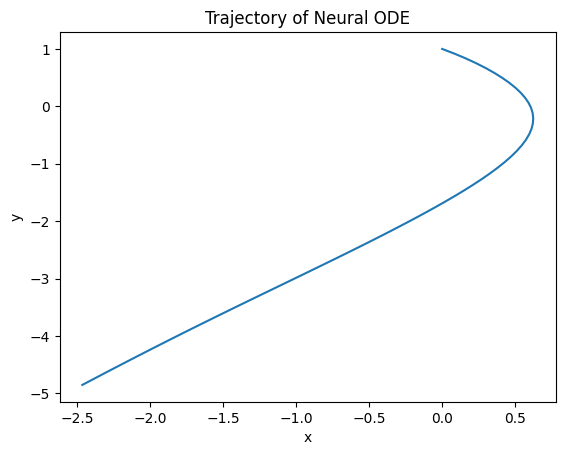

In [8]:
# Step 4: Visualizing the Solution
def plot_trajectory():
    t, y = solve_ode()                        # Solve the ODE and get the time and solution
    plt.plot(y[:, 0, 0].detach().numpy(), y[:, 0, 1].detach().numpy())  # Plot the trajectory
    plt.title('Trajectory of Neural ODE')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Call the function to visualize the solution
plot_trajectory()

In [13]:
# Step 1: Define the Neural ODE Model
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),   # Input dimension is 2, hidden layer size is 50
            nn.Tanh(),          # Activation function (Tanh)
            nn.Linear(50, 2)    # Output dimension is 2
        )

    def forward(self, t, y):
        return self.net(y)  # Forward pass: returns the time derivative of the state

    
# Step 2: Create Synthetic Data for Training
def generate_data():
    y0 = torch.tensor([[1.0, 0.0]])  # [1, 2]
    t = torch.linspace(0, 25, 100)

    # Circular motion: y = [cos(t), sin(t)]
    true_y = torch.stack([torch.cos(t), torch.sin(t)], dim=1).unsqueeze(1)  # [100, 1, 2]

    data = {'y0': y0, 't': t, 'y_true': true_y}
    return data

# Step 3: Define the Training Loop
def train_ode(model, optimizer, criterion, data):
    for epoch in range(100):                    # Number of epochs (iterations)
        optimizer.zero_grad()                   # Clear gradients from the previous step
        pred_y = odeint(model, data['y0'], data['t'])  # Solve ODE for current model state
        loss = criterion(pred_y, data['y_true'])  # Compute loss between predicted and true values
        loss.backward()                         # Backpropagate the error
        optimizer.step()                        # Update the model parameters
        if (epoch + 1) % 10 == 0:               # Print every 10 epochs
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')


model = ODEFunc()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

data = generate_data()

train_ode(model, optimizer, criterion, data)


Epoch 10, Loss: 0.5422962307929993
Epoch 20, Loss: 0.5310707688331604
Epoch 30, Loss: 0.5215147137641907
Epoch 40, Loss: 0.5172035694122314
Epoch 50, Loss: 0.5132923722267151
Epoch 60, Loss: 0.5104357600212097
Epoch 70, Loss: 0.5080385208129883
Epoch 80, Loss: 0.5060413479804993
Epoch 90, Loss: 0.5043345093727112
Epoch 100, Loss: 0.5028397440910339


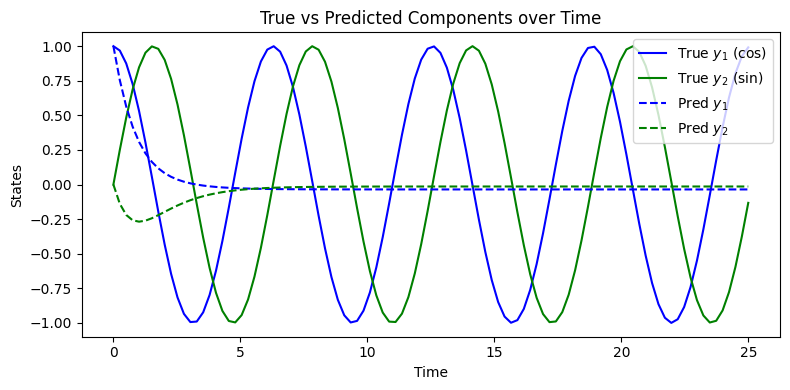

In [14]:
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import torch

def plot_results(model, data):
    with torch.no_grad():
        pred_y = odeint(model, data['y0'], data['t'])  # [T, 1, 2]

    t = data['t'].cpu().numpy()
    true_y = data['y_true'].squeeze(1).cpu().numpy()  # [T, 2]
    pred_y = pred_y.squeeze(1).cpu().numpy()          # [T, 2]

    plt.figure(figsize=(8,4))
    plt.plot(t, true_y[:,0], 'b', label='True $y_1$ (cos)')
    plt.plot(t, true_y[:,1], 'g', label='True $y_2$ (sin)')
    plt.plot(t, pred_y[:,0], 'b--', label='Pred $y_1$')
    plt.plot(t, pred_y[:,1], 'g--', label='Pred $y_2$')
    plt.xlabel('Time')
    plt.ylabel('States')
    plt.legend()
    plt.title('True vs Predicted Components over Time')
    plt.tight_layout()
    plt.show()
plot_results(model, data)

In [11]:
print("learned ω =", model.w.item())


learned ω = 1.5599067211151123


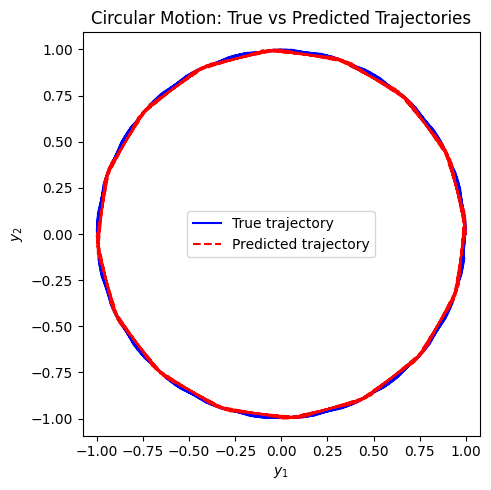

In [12]:
def plot_trajectory(model, data):
    with torch.no_grad():
        pred_y = odeint(model, data['y0'], data['t'])  # [T, 1, 2]

    true_y = data['y_true'].squeeze(1).cpu().numpy()  # [T, 2]
    pred_y = pred_y.squeeze(1).cpu().numpy()          # [T, 2]

    plt.figure(figsize=(5,5))
    plt.plot(true_y[:,0], true_y[:,1], 'b', label='True trajectory')
    plt.plot(pred_y[:,0], pred_y[:,1], 'r--', label='Predicted trajectory')
    plt.xlabel('$y_1$')
    plt.ylabel('$y_2$')
    plt.axis('equal')
    plt.legend()
    plt.title('Circular Motion: True vs Predicted Trajectories')
    plt.tight_layout()
    plt.show()

plot_trajectory(model, data)